# 🔍🧪 Some functions for analysis

### Originally created by Dr. A. Denvil-Sommer (NCAS, Univerity of Reading).

In this notebook, you’ll find a collection of reusable functions designed to help you analyze your simulation outputs and test specific hypotheses. Each function targets a common type of climate diagnostic — from global means to seasonal variability — so you can quickly explore the effects of different experimental setups.

**Function list and descriptions:**

`area_weights` — Computes cosine-latitude weights for global averaging.
This is a general-purpose utility you’ll use across most diagnostics to account for the fact that grid cells near the poles cover less surface area than those near the equator.

`seasonal_mean` — Groups a variable into climatological seasons (DJF, MAM, JJA, SON) and computes the mean for each.
Useful for summarizing long simulations into seasonal averages.

`plot_global_time_mean_map` — Produces maps of time-averaged fields such as temperature, precipitation, radiation, humidity, or wind magnitude.

`plot_global_time_mean_difference_map` — Same as above, but plots the spatial difference between two simulations to highlight changes caused by experimental perturbations.

`plot_seasonal_time_series_by_sim` — Plots seasonal averages of global mean variables (e.g., temperature, precipitation) for each simulation, broken down by DJF, MAM, JJA, SON.
Useful for detecting seasonal shifts in trends.

`plot_timeseries` — Plots globally averaged trends in time (temperature, humidity, precipitation, etc.).
Ideal for identifying long-term trends or step changes between experiments.

`plot_jet_stream` — Plots zonal wind profiles to visualize jet stream position and intensity.
This can help identify shifts in atmospheric circulation.

`seasonal_stddev` — Calculates the interannual variability of a seasonal mean (e.g., DJF temperature standard deviation year-to-year).
This is particularly useful for ENSO-like variability diagnostics.

`seasonal_stddev_all` — Similar to seasonal_stddev, but computes the standard deviation over the full time series of a given season (without averaging over each year first).
This gives a broader measure of seasonal variability.

`plot_wind_850hPa_map` — Plots lat–lon wind vectors and magnitude at ~850 hPa to visualize the jet entrance region.

`plot_meridional_circulation` — Computes and plots a zonal mean meridional circulation proxy (Hadley/Ferrel cells) using meridional wind and pressure tendency or level thickness.

`plot_surface_energy_balance` — Visualizes the net shortwave, net longwave, sensible, and latent heat fluxes at the surface, either as maps or globally averaged values.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import os

In [58]:
# --- HELPER FUNCTIONS ---
def area_weights(ds):
    """Compute cosine-latitude weights for global averaging"""
    weights = np.cos(np.deg2rad(ds.lat))
    return weights / weights.mean()

def plot_global_time_mean_map(datasets, varname="temp", title_base="", units="", is_surface_temp=False, vmin=None, vmax=None):
#for maps of mean temperature, precipitation, radiation, humidity, wind magnitude, etc.
    # Determine vmin/vmax if not set manually
    if vmin is None or vmax is None:
        all_means = []
        for ds in datasets.values():
            data = ds[varname]
            if is_surface_temp and "layer" in data.dims:
                data = data.isel(layer=-1)
            data_mean = data.mean(dim="time")
            all_means.append(data_mean)

        combined = xr.concat(all_means, dim="combined")
        vmin = float(combined.min())
        vmax = float(combined.max())

    # Setup figure and axes
    n = len(datasets)
    fig, axs = plt.subplots(1, n, figsize=(6 * n, 4),
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            constrained_layout=True)

    if n == 1:
        axs = [axs]  # Ensure iterable

    # Plotting
    for ax, (label, ds) in zip(axs, datasets.items()):
        data = ds[varname]
        if is_surface_temp and "layer" in data.dims:
            data = data.isel(layer=-1)
        data_mean = data.mean(dim="time")

        # Add cyclic point to avoid white stripe
        data_mean_cyclic, lon_cyclic = add_cyclic_point(data_mean, coord=ds.lon)

        pcm = ax.pcolormesh(
            lon_cyclic, ds.lat, data_mean_cyclic,
            transform=ccrs.PlateCarree(),
            cmap="coolwarm", vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{title_base}\n{label}")
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=":")
        ax.gridlines(draw_labels=True)

    # Add shared colorbar
    cbar = fig.colorbar(pcm, ax=axs, orientation="vertical", fraction=0.04, pad=0.02)
    cbar.set_label(units)

    plt.suptitle(f"Global Time-Mean {title_base}", fontsize=14)
    plt.show()

def plot_global_time_mean_difference_map(ds1, ds2, label1="Control", label2="Perturbed",
                                         varname="temp", title_base="", units="", is_surface_temp=False, vmin=None, vmax=None):
    # Extract the variable and surface layer if needed
    da1 = ds1[varname]
    da2 = ds2[varname]
    if is_surface_temp:
        if "layer" in da1.dims:
            da1 = da1.isel(layer=-1)
        if "layer" in da2.dims:
            da2 = da2.isel(layer=-1)

    # Compute time mean
    mean1 = da1.mean(dim="time")
    mean2 = da2.mean(dim="time")
    
    # Compute difference
    diff = mean2 - mean1

    # Add cyclic point for proper wrapping
    diff_cyclic, lon_cyclic = add_cyclic_point(diff, coord=ds1.lon)

    # Define color limits
    if vmin is not None and vmax is not None:
       levels = np.linspace(vmin, vmax, 21)
    else:
       abs_max = float(np.abs(diff_cyclic).max())
       levels = np.linspace(-abs_max, abs_max, 21)
       vmin, vmax = -abs_max, abs_max

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    pcm = ax.contourf(lon_cyclic, ds1.lat, diff_cyclic,
                      transform=ccrs.PlateCarree(), cmap="bwr", levels=levels, extend="both", vmin=vmin, vmax=vmax)

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.gridlines(draw_labels=True)
    ax.set_title(f"{title_base}\n{label2} – {label1}")

    # Colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8)
    cbar.set_label(f"Δ {units}")

    plt.suptitle(f"Difference in Global Mean (Time-Averaged) {title_base}", fontsize=14)
    plt.show()


def seasonal_mean(ds, varname):
    """Return a DataArray grouped by season"""
    return ds[varname].groupby("time.season").mean("time")

def plot_seasonal_time_series_by_sim(datasets, varname, title, units):
#for seasonal diagnostics of global means (e.g., temp, precip)
    seasons = ["DJF", "MAM", "JJA", "SON"]
    colors = {
        "DJF": "tab:blue",
        "MAM": "tab:green",
        "JJA": "tab:orange",
        "SON": "tab:red"
    }

    plt.figure(figsize=(12,6))

    for label, ds in datasets.items():
        weights = area_weights(ds)

        # Surface temperature case
        if varname == 'temp':
            var = ds[varname].isel(layer=-1).weighted(weights).mean(dim=["lat", "lon"])
        else:
            var = ds[varname].weighted(weights).mean(dim=["lat", "lon"])

        # Add season and year as coordinates
        season = var["time.season"]
        year = var["time.year"]
        var.coords["season"] = season
        var.coords["year"] = year

        linestyle = "--" if "0.16" in label else "-"  # Dashed for perturbed run

        for season_name in seasons:
            try:
                # Extract values for this season, then group by year
                season_series = var.where(var.season == season_name, drop=True)
                yearly_mean = season_series.groupby("year").mean()
                plt.plot(
                    yearly_mean.year,
                    yearly_mean,
                    label=f"{label} - {season_name}",
                    color=colors[season_name],
                    linestyle=linestyle
                )
            except Exception as e:
                print(f"Skipping {label} - {season_name} due to error: {e}")

    plt.title(title)
    plt.ylabel(units)
    plt.xlabel("Year")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_timeseries(datasets, varname, title, units):
#for globally averaged trends in temperature, humidity, precipitation etc.
    plt.figure(figsize=(12,5))
    for label, ds in datasets.items():
        weights = area_weights(ds)
        if varname == 'temp':
            var = ds[varname].isel(layer=-1).weighted(weights).mean(dim=["lat", "lon"])
            plt.plot(ds.time, var, label=label)
        else: 
            if varname == 'precip_cond_rate':
                var = ds[varname].weighted(weights).mean(dim=["lat", "lon"])
                var = var.isel(time=slice(150, None))  # slice by index
                plt.plot(var.time, var, label=label)
            else:
                var = ds[varname].weighted(weights).mean(dim=["lat", "lon"])
                plt.plot(ds.time, var, label=label)
    plt.title(title)
    plt.ylabel(units)
    plt.xlabel("Time")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_jet_stream(ds, label, level_idx=3):
#to analyze how the jet stream shifts
    """Plot zonal wind at upper level (e.g. level=3 ≈ 200 hPa)"""
    u = ds["u"].isel(layer=level_idx)
    weights = area_weights(ds)
    u_zonal = u.mean(dim="lon")  # zonal mean
    u_mean = u_zonal.mean(dim="time")

    plt.plot(u_mean, ds.lat, label=label)

# --- FUNCTION: Compute DJF STD DEV of Surface Temperature ---
def seasonal_stddev(ds, varname, level=-1, season='DJF'):
#to estimate interannual variability (e.g., ENSO response)
    da = ds[varname]
    if "layer" in da.dims:
        da = da.isel(layer=level)
    da.coords["season"] = da["time.season"]
    da.coords["year"] = da["time.year"]
    da_season = da.where(da.season == season, drop=True)
    return da_season.groupby("year").mean("time").std("year")



# --- FUNCTION: Compute DJF STD DEV of Surface Temperature ---
def seasonal_stddev_all(ds, varname, level=-1, season='DJF'):
#to estimate interannual variability (e.g., ENSO response)
    da = ds[varname]
    if "layer" in da.dims:
        da = da.isel(layer=level)
    da.coords["season"] = da["time.season"]
    da.coords["year"] = da["time.year"]
    da_season = da.where(da.season == season, drop=True)
    return da_season.std("time")

def plot_wind_850hPa_map(ds, u_name="u", v_name="v", level_idx=5, title="850 hPa Winds"):
    """
    Plots lat-lon map of wind magnitude and vectors at a given model level (default ~850 hPa).
    level_idx should match the vertical index for ~850 hPa in your model.
    """

    fig, axs = plt.subplots(1, len(datasets), figsize=(6 * len(datasets), 5),
                            subplot_kw={"projection": ccrs.PlateCarree()},
                            constrained_layout=True)

    if len(datasets) == 1:
        axs = [axs]

    for ax, (label, ds) in zip(axs, datasets.items()):
        u = ds[u_name].isel(layer=level_idx).mean(dim="time")
        v = ds[v_name].isel(layer=level_idx).mean(dim="time")
        wind_mag = np.sqrt(u**2 + v**2)

        wind_mag_cyclic, lon_cyclic = add_cyclic_point(wind_mag, coord=ds.lon)
        u_cyclic, _ = add_cyclic_point(u, coord=ds.lon)
        v_cyclic, _ = add_cyclic_point(v, coord=ds.lon)

        pcm = ax.contourf(lon_cyclic, ds.lat, wind_mag_cyclic,
                          transform=ccrs.PlateCarree(),
                          cmap="viridis", levels=np.linspace(0, wind_mag_cyclic.max(), 15))
        ax.quiver(lon_cyclic[::5], ds.lat[::3],
                  u_cyclic[::3, ::5], v_cyclic[::3, ::5],
                  transform=ccrs.PlateCarree(), color="black", scale=400)
        ax.coastlines()
        ax.set_title(f"{label} — 850 hPa Winds")

    plt.colorbar(pcm, ax=axs, orientation="horizontal", label="Wind speed (m/s)")
    plt.show()

def plot_meridional_circulation(ds, v_name="v", level_idx=None, title="Meridional Circulation",vmin=None, vmax=None):
    """
    Plots zonal mean meridional wind for multiple levels to approximate Hadley/Ferrel cell shifts.
    If level_idx is None, all levels are plotted.
    """
    # Approximate pressure levels for SpeedyWeather's 8 layers (in hPa)
    if vmin is None or vmax is None:
        all_means = []
        for ds in datasets.values():
            data = ds[v_name]
            data_mean = data.mean(dim="time")
            data_mean_zonal = data_mean.mean(dim="lon")
            all_means.append(data_mean_zonal)

        combined = xr.concat(all_means, dim="combined")
        vmin = float(combined.min())
        vmax = float(combined.max())
    
    pressure_levels = [62.5, 187.5, 312.5, 437.5, 562.5, 687.5, 812.5, 937.5]
    level_dim = "layer"

    fig, axs = plt.subplots(1, len(datasets), figsize=(6 * len(datasets), 5), constrained_layout=True)

    if len(datasets) == 1:
        axs = [axs]

    for ax, (label, ds) in zip(axs, datasets.items()):
        v = ds[v_name].mean(dim="time")       # time mean
        v_zonal = v.mean(dim="lon")           # zonal mean

        pcm = ax.contourf(ds.lat, pressure_levels, v_zonal,
                          cmap="RdBu_r", levels=np.linspace(vmin, vmax, 21), extend="both")
        ax.set_title(f"{title}\n{label}")
        ax.set_xlabel("Latitude")
        ax.set_ylabel("Pressure (hPa)")
        #ax.invert_yaxis()  # 1000 hPa at bottom

        plt.colorbar(pcm, ax=ax, orientation="vertical", label="m/s")

    plt.show()


def plot_surface_energy_balance(datasets, title_base="Surface Energy Balance", level=None):
    """
    Plot time-mean surface energy budget components from SpeedyWeather outputs.

    Components:
    - Net shortwave radiation at surface
    - Net longwave radiation at surface
    - Sensible heat flux
    - Latent heat flux (converted from ef: kg/s/m² → W/m²)
    """

    # Latent heat of vaporization (J/kg)
    L_v = 2.5e6

    fig, axs = plt.subplots(1, len(datasets), figsize=(7 * len(datasets), 5),
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             constrained_layout=True)

    if len(datasets) == 1:
        axs = [axs]

    for ax, (label, ds) in zip(axs, datasets.items()):
        # --- Extract variables ---
        sru = ds["sru"]  # surface shortwave up
        srd = ds["srd"]  # surface shortwave down
        lru = ds["lru"]  # surface longwave up
        lrd = ds["lrd"]  # surface longwave down
        shf = ds["shf"]  # sensible heat flux (positive up, W/m²)
        ef  = ds["ef"]   # humidity flux (kg/s/m²)

        # --- Convert latent heat flux ---
        lhf = ef * L_v  # W/m²

        # --- Compute net fluxes ---
        net_sw = srd - sru        # Net shortwave at surface
        net_lw = lrd - lru        # Net longwave at surface

        # --- Time means ---
        net_sw_mean = net_sw.mean(dim="time")
        net_lw_mean = net_lw.mean(dim="time")
        shf_mean    = shf.mean(dim="time")
        lhf_mean    = lhf.mean(dim="time")

        # --- Total surface energy balance ---
        seb_total = net_sw_mean + net_lw_mean - shf_mean - lhf_mean
        # Note: sign convention depends on model output; here positive up means loss from surface

        # --- Add cyclic point for map plotting ---
        seb_cyclic, lon_cyclic = add_cyclic_point(seb_total, coord=ds.lon)

        # --- Plot ---
        pcm = ax.contourf(lon_cyclic, ds.lat, seb_cyclic,
                          transform=ccrs.PlateCarree(),
                          cmap="coolwarm", levels=np.linspace(-10, 10, 21), extend="both")

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=":")
        ax.gridlines(draw_labels=True)
        ax.set_title(f"{title_base}\n{label}")

        plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05, label="W/m²")

    plt.suptitle(f"{title_base} (Time Mean)", fontsize=14)
    plt.show()

In [3]:
base_path = "/Users/annasommer/Documents/Documents - J73343QGPF/HRCM/CMSS2025/Practical_Sessions/"
runs = {
    "Albedo 0.06": base_path + "run_Climate_Ocean_Albedo_const/output.nc",
    "Albedo 0.16": base_path + "run_Climate_Ocean_Albedo_const_016/output.nc"
}


In [4]:
# --- LOAD DATA ---
datasets = {label: xr.open_dataset(path) for label, path in runs.items()}


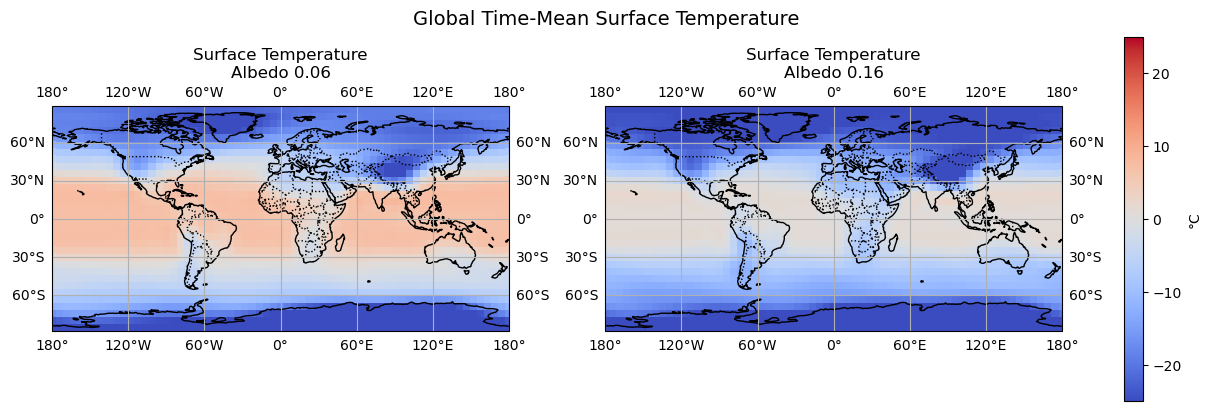

In [6]:
plot_global_time_mean_map(datasets, varname="temp", title_base="Surface Temperature", units="°C", is_surface_temp=True, vmin=-25, vmax=25)


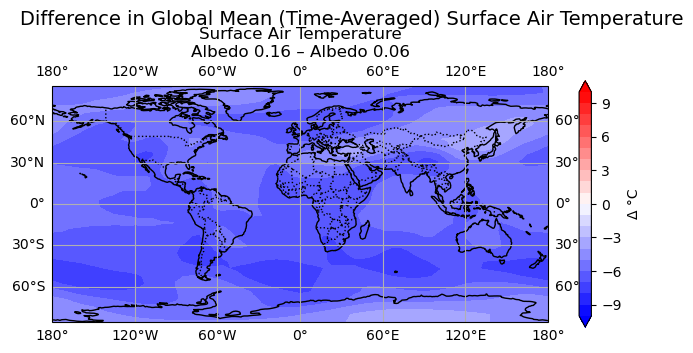

In [7]:
plot_global_time_mean_difference_map(
    ds1=datasets["Albedo 0.06"],
    ds2=datasets["Albedo 0.16"],
    label1="Albedo 0.06",
    label2="Albedo 0.16",
    varname="temp",
    title_base="Surface Air Temperature",
    units="°C",
    is_surface_temp=True,
    vmin=-10., vmax=10. 
)

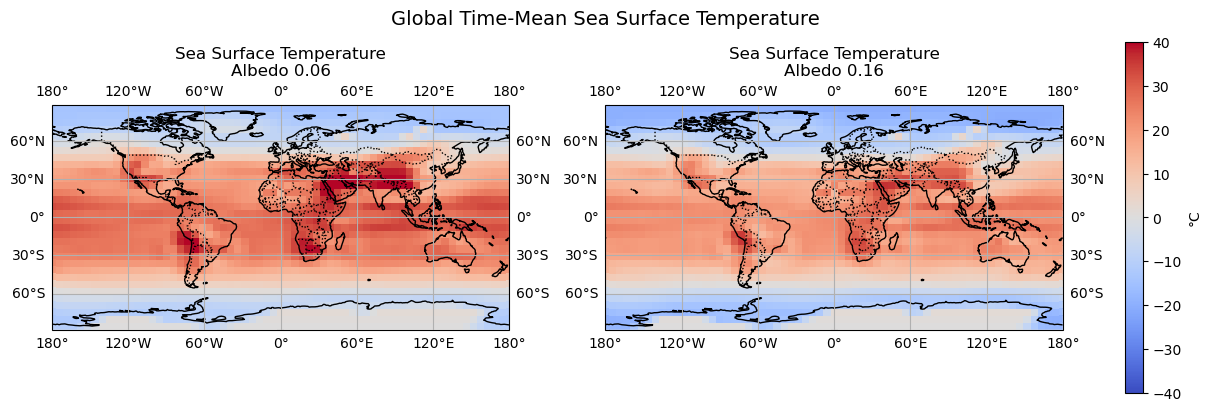

In [9]:
plot_global_time_mean_map(datasets, varname="sst", title_base="Sea Surface Temperature", units="°C", is_surface_temp=True, vmin=-40, vmax=40)


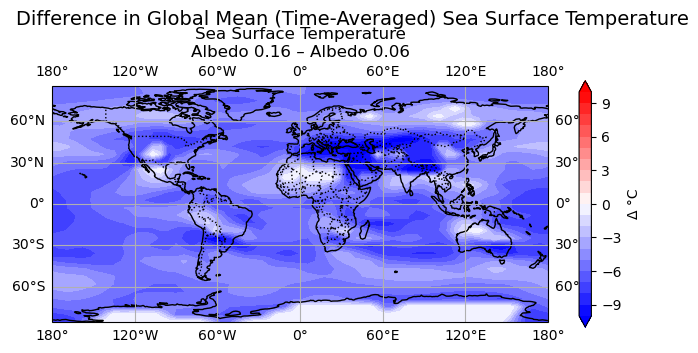

In [10]:
plot_global_time_mean_difference_map(
    ds1=datasets["Albedo 0.06"],
    ds2=datasets["Albedo 0.16"],
    label1="Albedo 0.06",
    label2="Albedo 0.16",
    varname="sst",
    title_base="Sea Surface Temperature",
    units="°C",
    vmin=-10, vmax=10
)

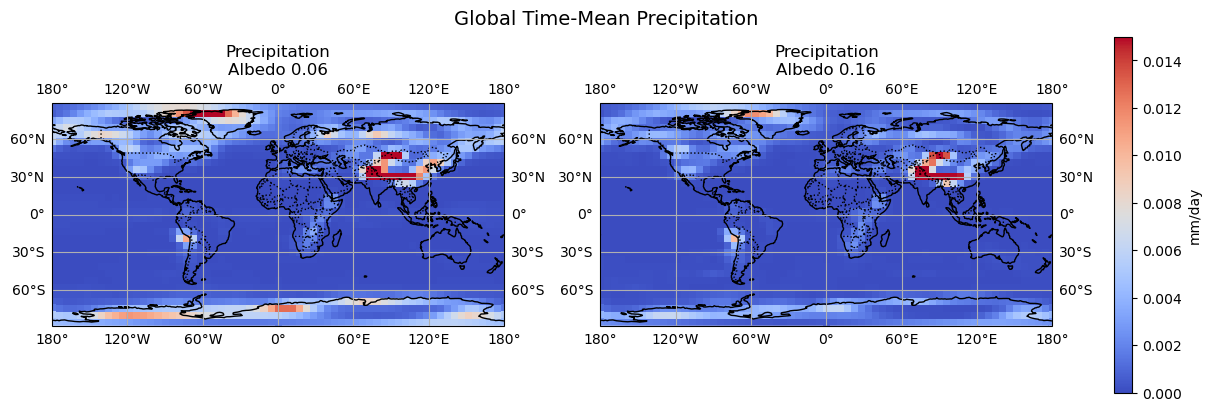

In [11]:
plot_global_time_mean_map(datasets, varname="precip_cond_rate", title_base="Precipitation", units="mm/day", vmin=0, vmax=0.015)

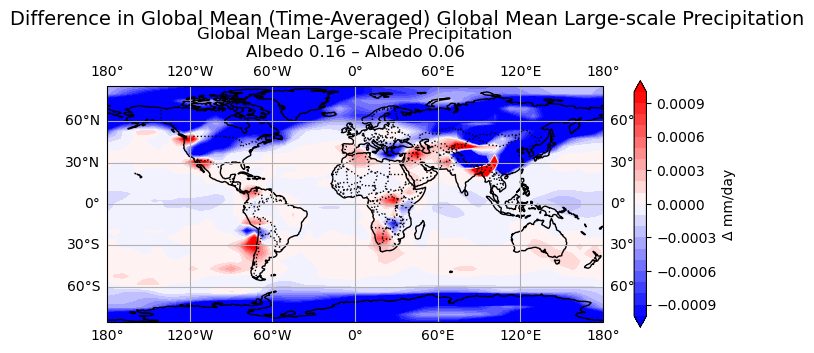

In [14]:
plot_global_time_mean_difference_map(
    ds1=datasets["Albedo 0.06"],
    ds2=datasets["Albedo 0.16"],
    label1="Albedo 0.06",
    label2="Albedo 0.16",
    varname="precip_cond_rate",
    title_base="Global Mean Large-scale Precipitation",
    units="mm/day",
    vmin=-0.001, vmax=0.001
)

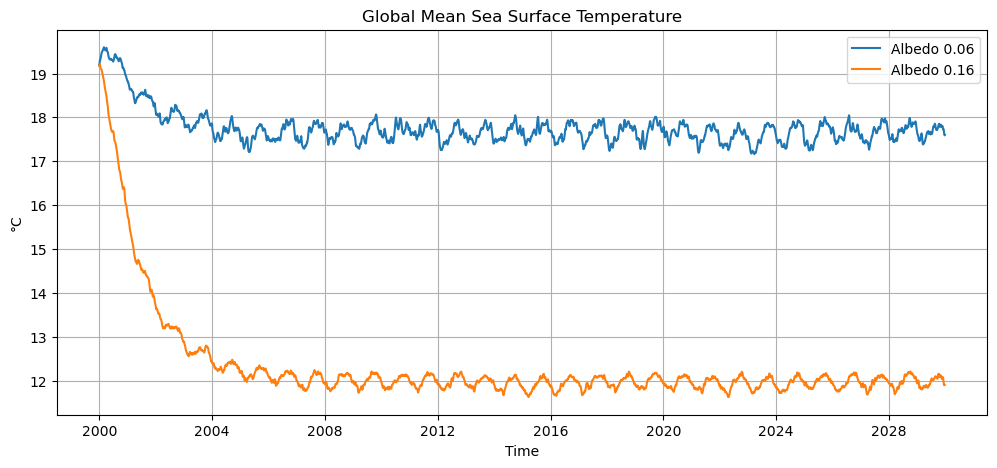

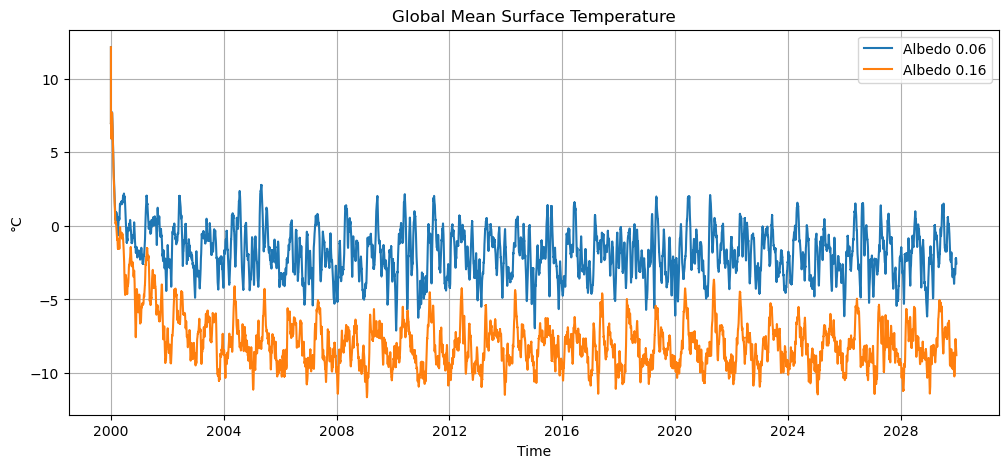

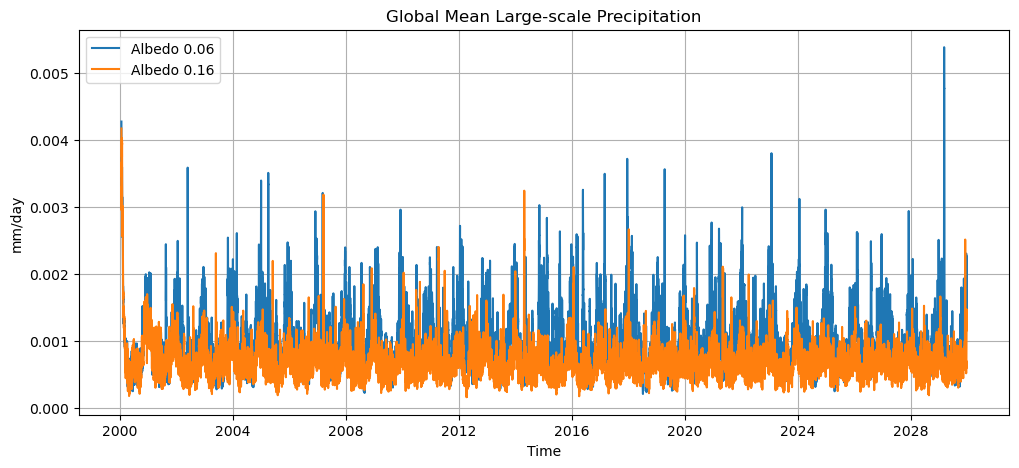

In [13]:
# --- PLOT GLOBAL MEANS ---
plot_timeseries(datasets, "sst", "Global Mean Sea Surface Temperature", "°C")
plot_timeseries(datasets, "temp", "Global Mean Surface Temperature", "°C")
plot_timeseries(datasets, "precip_cond_rate", "Global Mean Large-scale Precipitation", "mm/day")


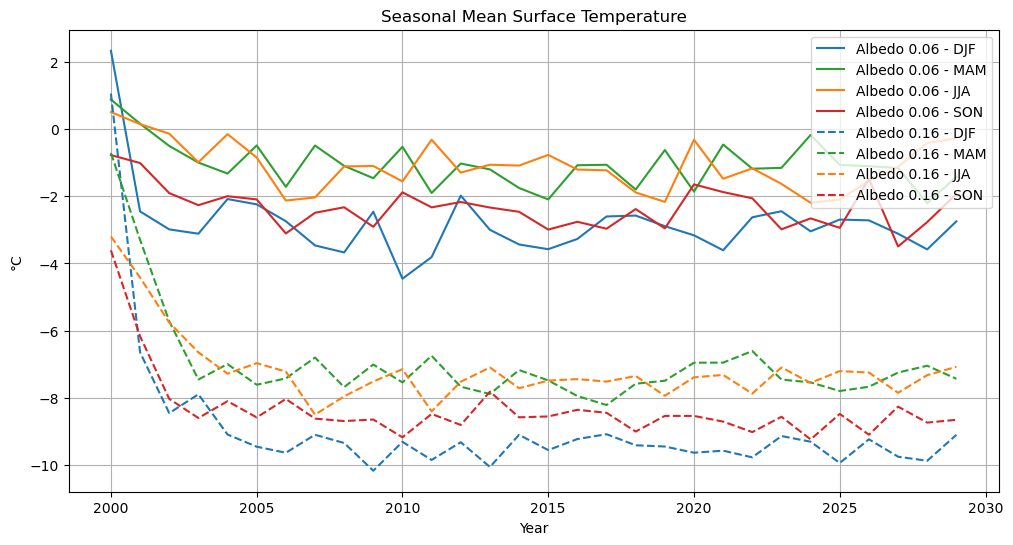

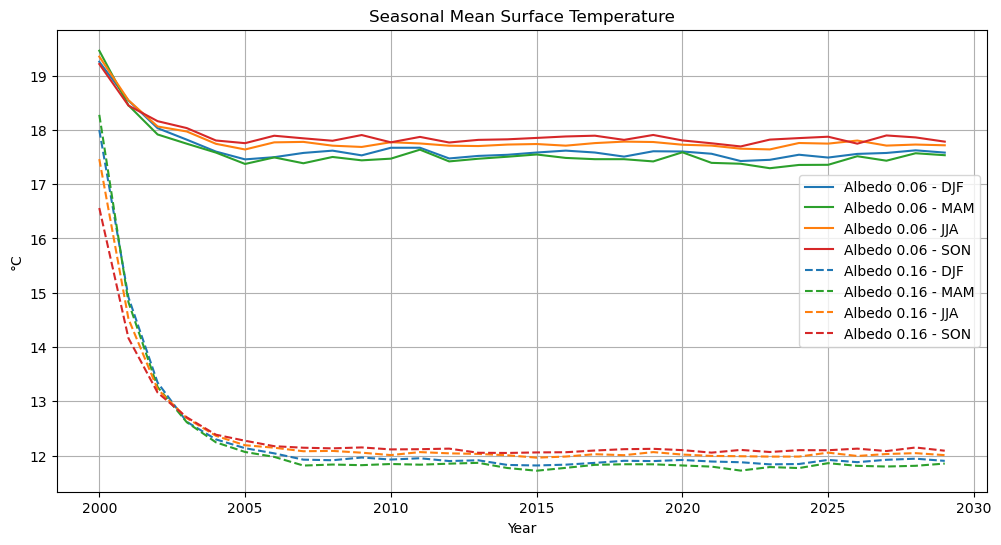

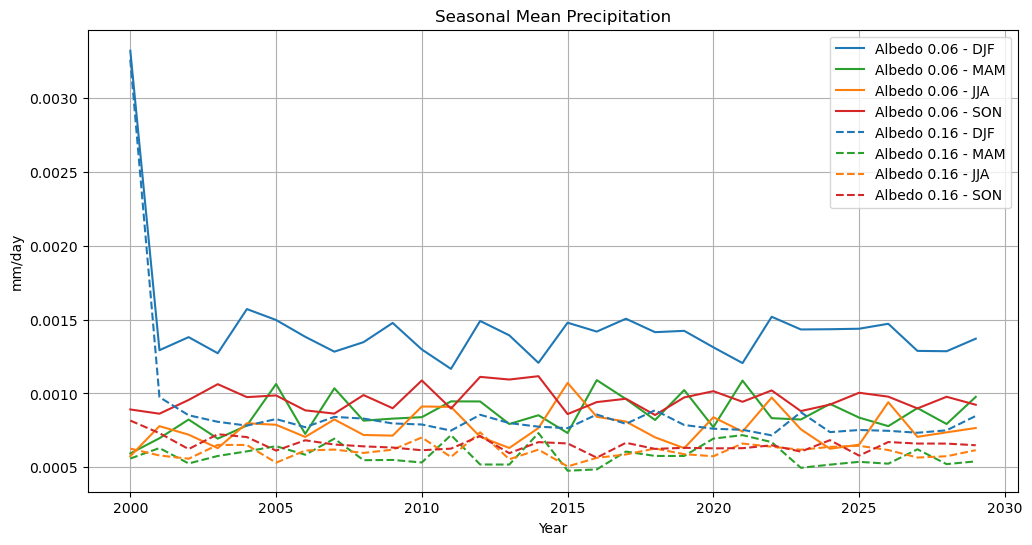

In [15]:
# --- SEASONAL MEANS ---
plot_seasonal_time_series_by_sim(datasets, "temp", "Seasonal Mean Surface Temperature", "°C")
plot_seasonal_time_series_by_sim(datasets, "sst", "Seasonal Mean Surface Temperature", "°C")
plot_seasonal_time_series_by_sim(datasets, "precip_cond_rate", "Seasonal Mean Precipitation", "mm/day")



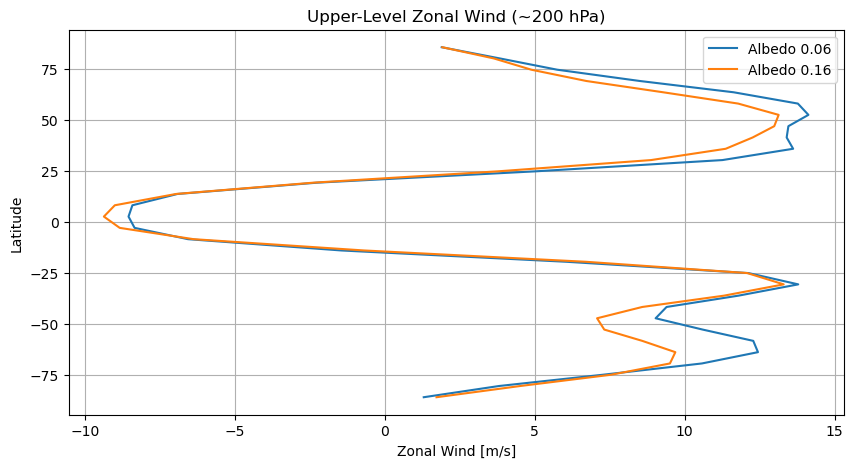

In [16]:
# --- ZONAL WIND / JET STREAM ---
plt.figure(figsize=(10,5))
for label, ds in datasets.items():
    plot_jet_stream(ds, label, level_idx=3)  # adjust level if needed
plt.title("Upper-Level Zonal Wind (~200 hPa)")
plt.xlabel("Zonal Wind [m/s]")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# --- CONFIGURATION ---
season = 'DJF'
varname = 'sst'
#varname = 'temp'
layer = -1  # Surface layer
units = "°C"

In [18]:
# --- COMPUTE ---
std_dev = {label: seasonal_stddev(ds, varname, level=layer, season=season)
           for label, ds in datasets.items()}
std_diff = std_dev["Albedo 0.16"] - std_dev["Albedo 0.06"]

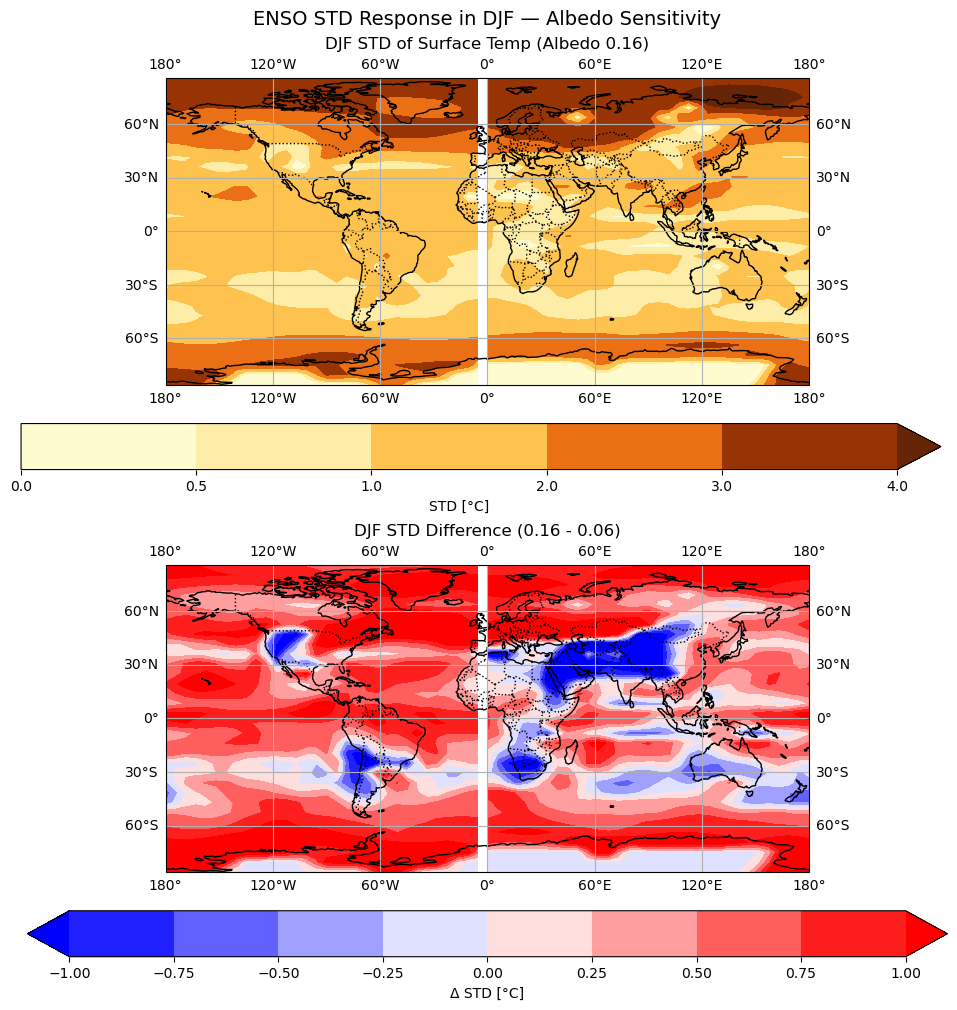

In [19]:
# --- PLOT ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

# --- Panel 1: STD for Albedo 0.16 ---
im1 = axs[0].contourf(std_dev["Albedo 0.16"].lon, std_dev["Albedo 0.16"].lat,
                      std_dev["Albedo 0.16"], levels=[0, 0.5, 1, 2, 3, 4],
                      cmap="YlOrBr", extend="max", transform=ccrs.PlateCarree())

axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=":")
axs[0].gridlines(draw_labels=True)
axs[0].set_title(f"{season} STD of Surface Temp (Albedo 0.16)")
plt.colorbar(im1, ax=axs[0], orientation="horizontal", label=f"STD [{units}]")

# --- Panel 2: Difference (Albedo 0.16 – 0.06) ---
im2 = axs[1].contourf(std_diff.lon, std_diff.lat, std_diff,
                      levels=np.linspace(-1, 1, 9), cmap="bwr", extend="both",
                      transform=ccrs.PlateCarree())

axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=":")
axs[1].gridlines(draw_labels=True)
axs[1].set_title(f"{season} STD Difference (0.16 - 0.06)")
plt.colorbar(im2, ax=axs[1], orientation="horizontal", label=f"Δ STD [{units}]")

plt.suptitle(f"ENSO STD Response in {season} — Albedo Sensitivity", fontsize=14)
plt.show()

In [20]:
# --- COMPUTE ---
std_dev_all = {label: seasonal_stddev_all(ds, varname, level=layer, season=season)
           for label, ds in datasets.items()}
std_diff_all = std_dev_all["Albedo 0.16"] - std_dev_all["Albedo 0.06"]

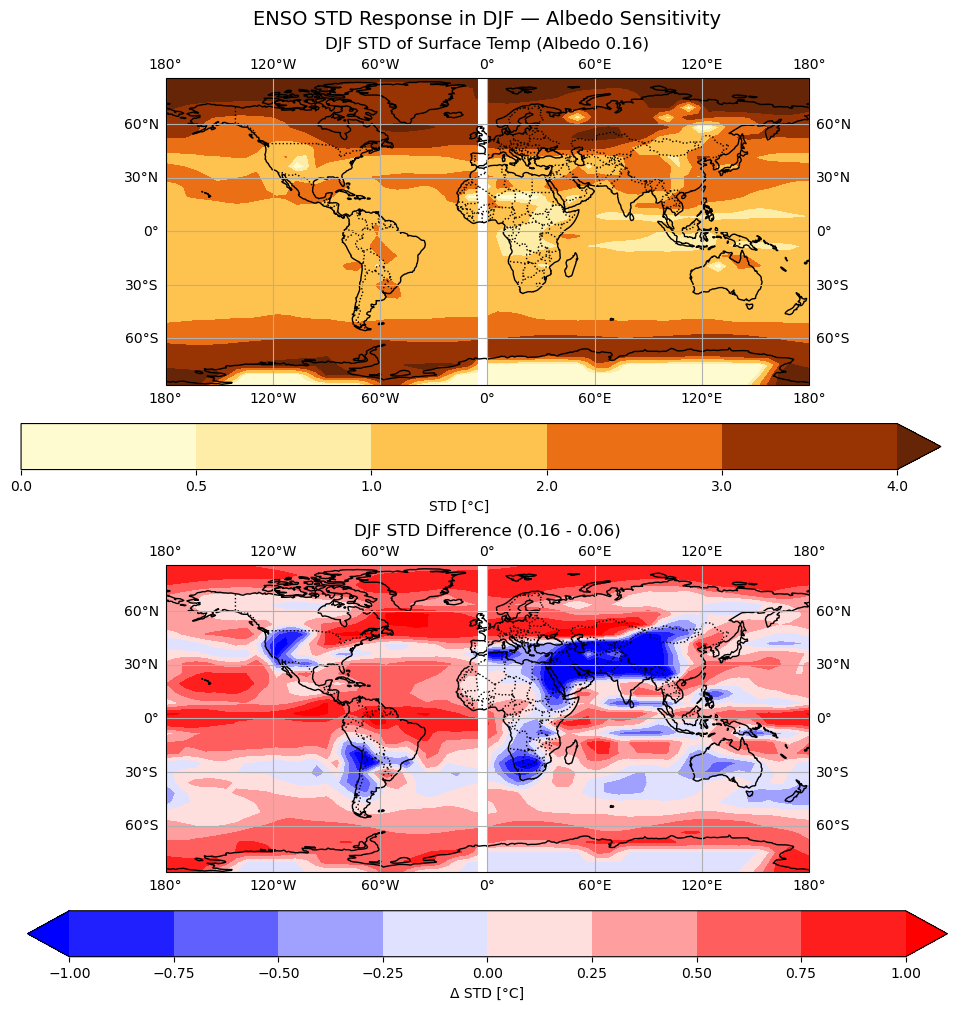

In [21]:
# --- PLOT ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

# --- Panel 1: STD for Albedo 0.16 ---
im1 = axs[0].contourf(std_dev_all["Albedo 0.16"].lon, std_dev_all["Albedo 0.16"].lat,
                      std_dev_all["Albedo 0.16"], levels=[0, 0.5, 1, 2, 3, 4],
                      cmap="YlOrBr", extend="max", transform=ccrs.PlateCarree())

axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle=":")
axs[0].gridlines(draw_labels=True)
axs[0].set_title(f"{season} STD of Surface Temp (Albedo 0.16)")
plt.colorbar(im1, ax=axs[0], orientation="horizontal", label=f"STD [{units}]")

# --- Panel 2: Difference (Albedo 0.16 – 0.06) ---
im2 = axs[1].contourf(std_diff_all.lon, std_diff_all.lat, std_diff_all,
                      levels=np.linspace(-1, 1, 9), cmap="bwr", extend="both",
                      transform=ccrs.PlateCarree())

axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle=":")
axs[1].gridlines(draw_labels=True)
axs[1].set_title(f"{season} STD Difference (0.16 - 0.06)")
plt.colorbar(im2, ax=axs[1], orientation="horizontal", label=f"Δ STD [{units}]")

plt.suptitle(f"ENSO STD Response in {season} — Albedo Sensitivity", fontsize=14)
plt.show()

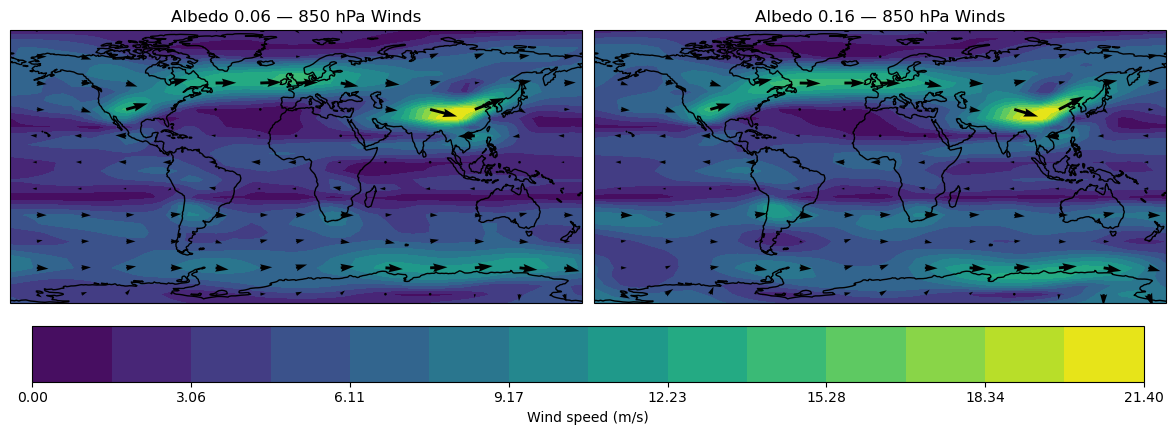

In [29]:
plot_wind_850hPa_map(datasets, u_name="u", v_name="v", level_idx=5, title="850 hPa Winds")

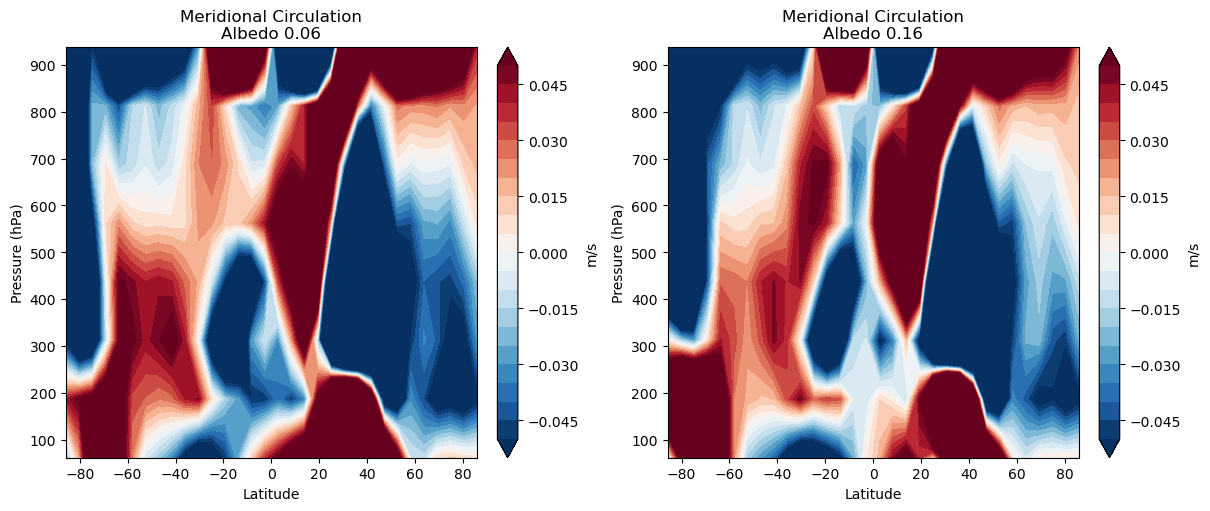

In [59]:
plot_meridional_circulation(datasets, "v", level_idx=None, title="Meridional Circulation",vmin=-0.05, vmax=0.05)

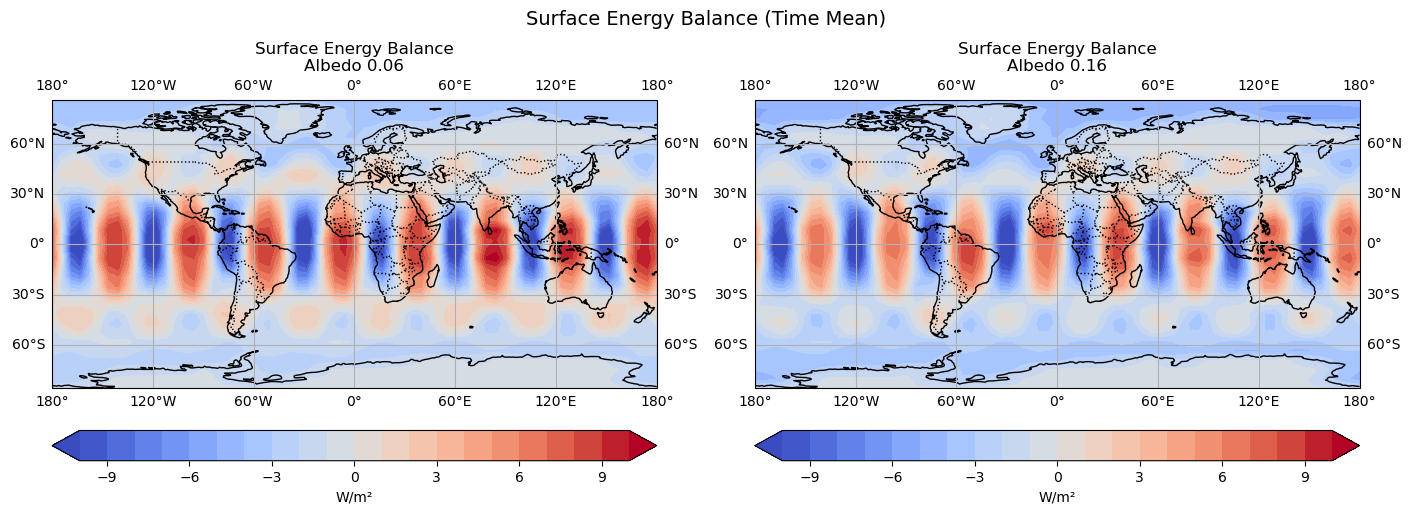

In [52]:
plot_surface_energy_balance(datasets, title_base="Surface Energy Balance", level=None)